In [1]:
import obspy
import glob
import matplotlib.pyplot as plt
import numpy as np
import datetime

## Read in original catalog

In [2]:
og_cat = obspy.core.event.read_events('data/endquakes_2017.xml')
og_cat = og_cat.filter("time > 2017-06-01","time < 2017-07-01")

## Read in output from ML picking

In [3]:
ml_cat = obspy.core.event.read_events('data/catalogs/2017.xml',format='QUAKEML')

## Read in output from template matching

In [169]:
tm_cat = obspy.core.event.catalog.Catalog()

# Remove duplicates as we go
dfiles = glob.glob('data/detections/*.xml')
for d in dfiles:
    with_dupes = obspy.core.event.read_events(d)
    without_dupes = remove_dupes(with_dupes,time_int=1)
    tm_cat.extend(without_dupes)

In [170]:
# Filter to only keep quality detections

keep_cat = obspy.core.event.catalog.Catalog()
for ev in tm_cat:
    s = ev.comments[2].text.split('=')[1]
    if float(s) > 2.5:
        keep_cat.extend([ev])
tm_cat = keep_cat

In [168]:
# Function for removing duplicates

def remove_dupes(starting_catalog,time_int):
    
    evs = [ev for ev in starting_catalog]
    
    keep_cat = obspy.core.event.catalog.Catalog()


    # Sort catalog by time
    times = []
    for ev in evs:
        times.append(ev.picks[0].time.datetime)
    sort_ind = np.argsort(times)
    times.sort()
    evs = [evs[si] for si in sort_ind]

    # Go through catalog and keep only events with
    # the highest detection value that occur more than time_int apart

    base_ind = 0
    while base_ind < len(evs):
        diffs = [t-times[base_ind] for t in times]
        comp_ind = [ind for ind,d in enumerate(diffs) if np.abs(d) < datetime.timedelta(seconds=time_int)]
        if len(comp_ind) > 1:
            vals = [float(evs[ci].comments[2].text.split('=')[1]) for ci in comp_ind]
            keep_ind = np.argmax(vals)
            keep_cat.extend([evs[comp_ind[keep_ind]]])
            base_ind = np.max(comp_ind) + 1
        else:
            keep_cat.extend([evs[base_ind]])
            base_ind += 1
           
    return(keep_cat)


## Make comparative plots

In [191]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [162]:
og_times = [ev.origins[0].time.datetime for ev in og_cat]
ml_times = [ev.origins[0].time.datetime for ev in ml_cat]
tm_times = [ev.picks[0].time.datetime for ev in tm_cat]

(17318.0, 17345.0)

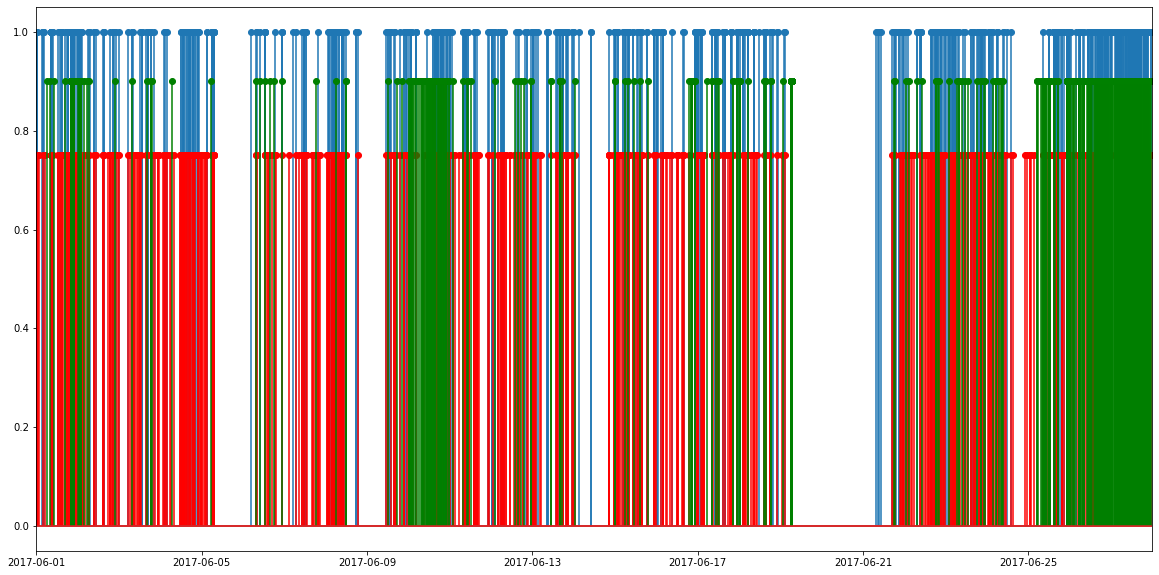

In [171]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ax.stem(ml_times,np.ones(len(ml_times)))
ax.stem(og_times,np.ones(len(og_times))*0.75,markerfmt='ro',linefmt='r')
ax.stem(tm_times,np.ones(len(tm_times))*0.9,markerfmt='go',linefmt='g')
ax.set_xlim(datetime.datetime(2017,6,1),datetime.datetime(2017,6,28))

#### Bar chart by hour

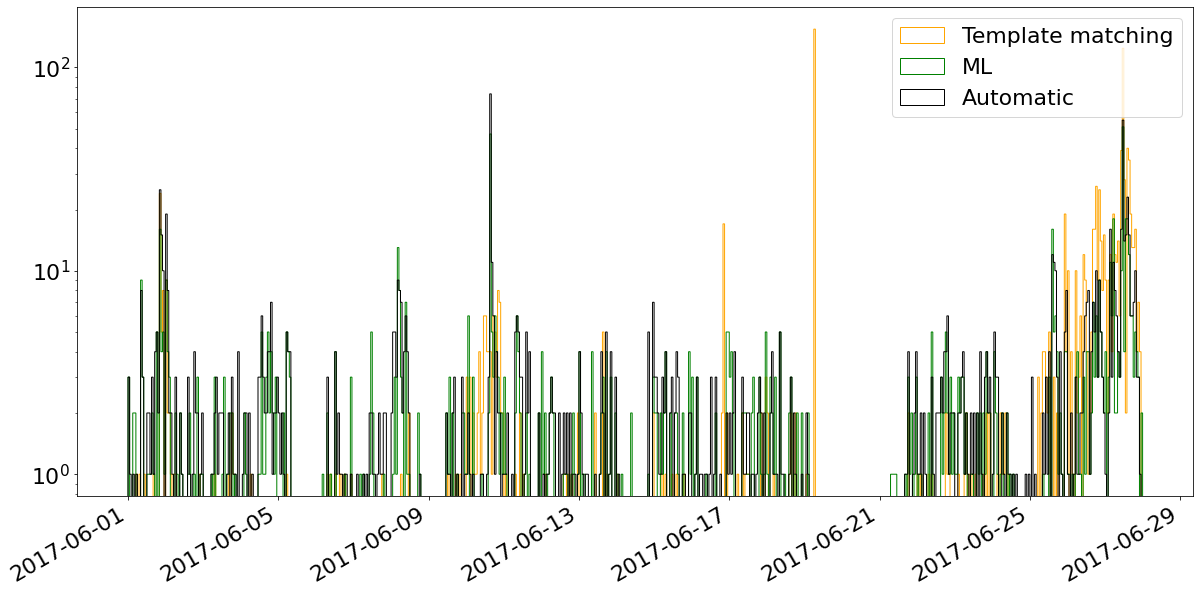

In [258]:
t1 = datetime.datetime(2017,6,1)
t2 = datetime.datetime(2017,6,28)

fig, ax = plt.subplots(figsize=(20,10))
tm_n,_,_ = ax.hist(tm_times, bins=27*24, range=(t1, t2),edgecolor='orange', linewidth=1.0, histtype='step')
ml_n,_,_ = ax.hist(ml_times, bins=27*24, range=(t1, t2),edgecolor='green', linewidth=1.0, histtype='step')
og_n,_,_ = ax.hist(og_times, bins=27*24, range=(t1, t2),edgecolor='black', linewidth=1.0, histtype='step')
ax.legend(['Template matching','ML','Automatic'])
ax.set_yscale('log')
fig.autofmt_xdate()
fig.show()

In [236]:
tm_comp = [tm_n[i]-og_n[i] for i in range(len(tm_n))]
ml_comp = [ml_n[i]-og_n[i] for i in range(len(tm_n))]

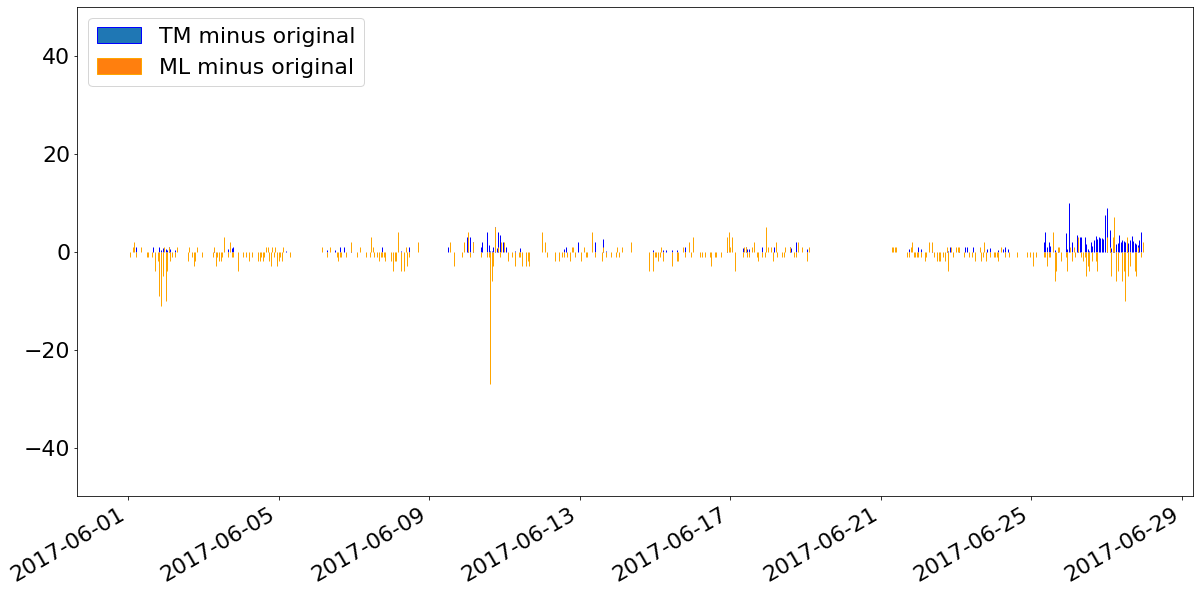

In [270]:
time_bins = np.arange(t1,t2,datetime.timedelta(hours=1))

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(time_bins,tm_comp,color=None,edgecolor='blue',width=3)
ax.bar(time_bins,ml_comp,color=None,edgecolor='orange',width=3)
ax.set_ylim(-50,50)
ax.legend(['TM minus original','ML minus original'],loc='upper left')
fig.autofmt_xdate()
fig.show()